# Forest Fire Hotspot Detection
# by:
# Muhammad Haris Saad - 24100055
# Taha Sarwat - 25100287

### Import Libraries

In [ ]:
import numpy as np
import pandas as pd
import random
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import IsolationForest
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.cluster import MeanShift
from sklearn.cluster import Birch
from sklearn.cluster import DBSCAN
import skfuzzy as fuzz

# !pip install simpful
import simpful as sf

# from google.colab import drive
# drive.mount("/content/drive")

### Function for conducting Exploratory Data Analysis of a given dataset

In [ ]:
def eda_of_df(df: pd.DataFrame):
    display(df)
    print(f"Shape = {df.shape}\n")
    print(f"\nInformation:\n{df.info()}\n")
    print(f"Description:\n{df.describe()}\n")
    print(f"Null values:\n{df.isnull().sum()}\n")
    print(f"Unique values:\n{df.nunique()}\n")

    corr_matrix = df.corr()
    plt.figure(figsize=(12, 10))
    sns.heatmap(corr_matrix, annot=True, cmap="coolwarm", fmt=".2f")
    plt.title("Correlation Matrix of Forest Fires Dataset")
    plt.show()

### Import datasets and show their details

### Montesinho Natural Park Forest Fires dataset

This dataset has been acquired from Kaggle: https://www.kaggle.com/datasets/elikplim/forest-fires-data-set

It focuses on the data acquired from Montesinho Natural Park, Northeastern Portugal.

Its attributes are as follows:

X - x-axis sfatial coordinate within the Montesinho park map: 1 to 9

Y - y-axis spatial coordinate within the Montesinho park map: 2 to 9

month - month of the year: "jan" to "dec"

day - day of the week: "mon" to "sun"

FFMC - Fine Fuel Moisture Code index from the FWI system: 18.7 to 96.20

DMC - Duff Moisture Code index from the FWI system: 1.1 to 291.3

DC - Drought Code index from the FWI system: 7.9 to 860.6

ISI - Initial Spread Index from the FWI system: 0.0 to 56.10

temp - temperature in Celsius degrees: 2.2 to 33.30

RH - relative humidity in %: 15.0 to 100

wind - wind speed in km/h: 0.40 to 9.40

rain - outside rain in mm/m2 : 0.0 to 6.4

area - the burned area of the forest (in ha): 0.00 to 1090.84 (this output variable is very skewed towards 0.0, thus it may make sense to model with the logarithm transform).

In [ ]:
mnp_forest_fires_df = pd.read_csv("Datasets/forestfires.csv")

##### Perform Preprocessing on this dataset

In [ ]:
for i in range(len(mnp_forest_fires_df["area"])):
    if mnp_forest_fires_df["area"][i] > 0:
        mnp_forest_fires_df["area"][i] = 1
    else:
        mnp_forest_fires_df["area"][i] = 0

mnp_forest_fires_df.rename(columns={"area": "Fire"}, inplace=True)

/tmp/ipykernel_27595/3986401740.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  mnp_forest_fires_df["area"][i] = 0
/tmp/ipykernel_27595/3986401740.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  mnp_forest_fires_df["area"][i] = 1


,X,Y,month,day,FFMC,DMC,DC,ISI,temp,RH,wind,rain,Fire
0,7,5,mar,fri,86.2,26.2,94.3,5.1,8.2,51,6.7,0.0,0.0
1,7,4,oct,tue,90.6,35.4,669.1,6.7,18.0,33,0.9,0.0,0.0
2,7,4,oct,sat,90.6,43.7,686.9,6.7,14.6,33,1.3,0.0,0.0
3,8,6,mar,fri,91.7,33.3,77.5,9.0,8.3,97,4.0,0.2,0.0
4,8,6,mar,sun,89.3,51.3,102.2,9.6,11.4,99,1.8,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
512,4,3,aug,sun,81.6,56.7,665.6,1.9,27.8,32,2.7,0.0,1.0
513,2,4,aug,sun,81.6,56.7,665.6,1.9,21.9,71,5.8,0.0,1.0
514,7,4,aug,sun,81.6,56.7,665.6,1.9,21.2,70,6.7,0.0,1.0
515,1,4,aug,sat,94.4,146.0,614.7,11.3,25.6,42,4.0,0.0,0.0


Shape = (517, 13)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 517 entries, 0 to 516
Data columns (total 13 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   X       517 non-null    int64  
 1   Y       517 non-null    int64  
 2   month   517 non-null    object 
 3   day     517 non-null    object 
 4   FFMC    517 non-null    float64
 5   DMC     517 non-null    float64
 6   DC      517 non-null    float64
 7   ISI     517 non-null    float64
 8   temp    517 non-null    float64
 9   RH      517 non-null    int64  
 10  wind    517 non-null    float64
 11  rain    517 non-null    float64
 12  Fire    517 non-null    float64
dtypes: float64(8), int64(3), object(2)
memory usage: 52.6+ KB

Information:
None

Description:
                X           Y        FFMC         DMC          DC         ISI  \
count  517.000000  517.000000  517.000000  517.000000  517.000000  517.000000   
mean     4.669246    4.299807   90.644681  110.872340  547.9400

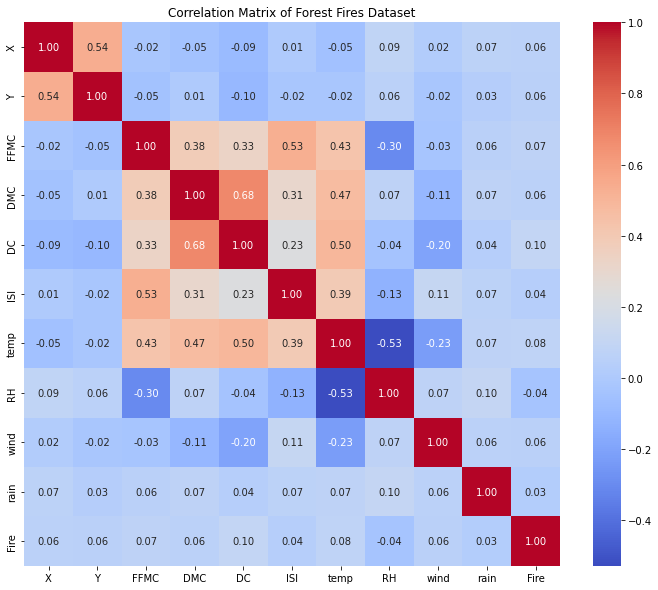

In [ ]:
eda_of_df(mnp_forest_fires_df)

##### Hence we reject this dataset as the correlations of all the variables with Fire is incredibly low, even for variables that should otherwise have high correlation such as Temperature, Wind Speed, and FFMC etc.

### Algerian Forest Fires dataset

This dataset has been taken from Kaggle: https://www.kaggle.com/datasets/nitinchoudhary012/algerian-forest-fires-dataset

After preprocessing (performed below), it has the following attributes:

day: min = 1, max = 31

month: min = 6, max = 9

year: min = 2012, max = 2012

Temperature: min = 22, max = 42

RH: min = 21, max = 90

Ws: min = 6, max = 29

Rain: min = 0.0, max = 16.8

FFMC: min = 28.6, max = 96.0

DMC: min = 0.7, max = 65.9

DC: min = 6.9, max = 220.4

ISI: min = 0.0, max = 19.0

BUI: min = 1.1, max = 68.0

FWI: min = 0.0, max = 31.1

Fire: No fire = 0, Fire = 1

In [ ]:
alg_forest_fires_df = pd.read_csv("Datasets/Algerian_forest_fires_dataset.csv")

##### Perform Data Cleaning and Preprocessing on this dataset

In [ ]:
alg_forest_fires_df = alg_forest_fires_df.dropna(axis=0).reset_index(drop=True)
alg_forest_fires_df = alg_forest_fires_df.drop(122).reset_index(drop=True)
alg_forest_fires_df.columns = alg_forest_fires_df.columns.str.strip()
alg_forest_fires_df[["month", "day", "year", "Temperature", "RH", "Ws"]] = alg_forest_fires_df[["month", "day", "year", "Temperature", "RH", "Ws"]].astype(int)
alg_forest_fires_df[["Rain", "FFMC", "DMC", "DC", "ISI", "BUI", "FWI"]] = alg_forest_fires_df[["Rain", "FFMC", "DMC", "DC", "ISI", "BUI", "FWI"]].astype(float)

for i in range(len(alg_forest_fires_df["Classes"])):
    alg_forest_fires_df["Classes"][i] = alg_forest_fires_df["Classes"][i].strip()
classes_col = {"not fire": 0, "fire": 1}
alg_forest_fires_df = alg_forest_fires_df.replace({"Classes": classes_col})

for col in alg_forest_fires_df.columns:
    print(f"{col}: min = {alg_forest_fires_df[col].min()}, max = {alg_forest_fires_df[col].max()}")
alg_forest_fires_df.rename(columns={"Classes": "Fire"}, inplace=True)

day: min = 1, max = 31
month: min = 6, max = 9
year: min = 2012, max = 2012
Temperature: min = 22, max = 42
RH: min = 21, max = 90
Ws: min = 6, max = 29
Rain: min = 0.0, max = 16.8
FFMC: min = 28.6, max = 96.0
DMC: min = 0.7, max = 65.9
DC: min = 6.9, max = 220.4
ISI: min = 0.0, max = 19.0
BUI: min = 1.1, max = 68.0
FWI: min = 0.0, max = 31.1
Classes: min = 0, max = 1


/tmp/ipykernel_27595/2559171475.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  alg_forest_fires_df["Classes"][i] = alg_forest_fires_df["Classes"][i].strip()


,day,month,year,Temperature,RH,Ws,Rain,FFMC,DMC,DC,ISI,BUI,FWI,Fire
0,1,6,2012,29,57,18,0.0,65.7,3.4,7.6,1.3,3.4,0.5,0
1,2,6,2012,29,61,13,1.3,64.4,4.1,7.6,1.0,3.9,0.4,0
2,3,6,2012,26,82,22,13.1,47.1,2.5,7.1,0.3,2.7,0.1,0
3,4,6,2012,25,89,13,2.5,28.6,1.3,6.9,0.0,1.7,0.0,0
4,5,6,2012,27,77,16,0.0,64.8,3.0,14.2,1.2,3.9,0.5,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
238,26,9,2012,30,65,14,0.0,85.4,16.0,44.5,4.5,16.9,6.5,1
239,27,9,2012,28,87,15,4.4,41.1,6.5,8.0,0.1,6.2,0.0,0
240,28,9,2012,27,87,29,0.5,45.9,3.5,7.9,0.4,3.4,0.2,0
241,29,9,2012,24,54,18,0.1,79.7,4.3,15.2,1.7,5.1,0.7,0


Shape = (243, 14)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 243 entries, 0 to 242
Data columns (total 14 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   day          243 non-null    int64  
 1   month        243 non-null    int64  
 2   year         243 non-null    int64  
 3   Temperature  243 non-null    int64  
 4   RH           243 non-null    int64  
 5   Ws           243 non-null    int64  
 6   Rain         243 non-null    float64
 7   FFMC         243 non-null    float64
 8   DMC          243 non-null    float64
 9   DC           243 non-null    float64
 10  ISI          243 non-null    float64
 11  BUI          243 non-null    float64
 12  FWI          243 non-null    float64
 13  Fire         243 non-null    int64  
dtypes: float64(7), int64(7)
memory usage: 26.7 KB

Information:
None

Description:
              day       month    year  Temperature          RH          Ws  \
count  243.000000  243.000000   243.0   24

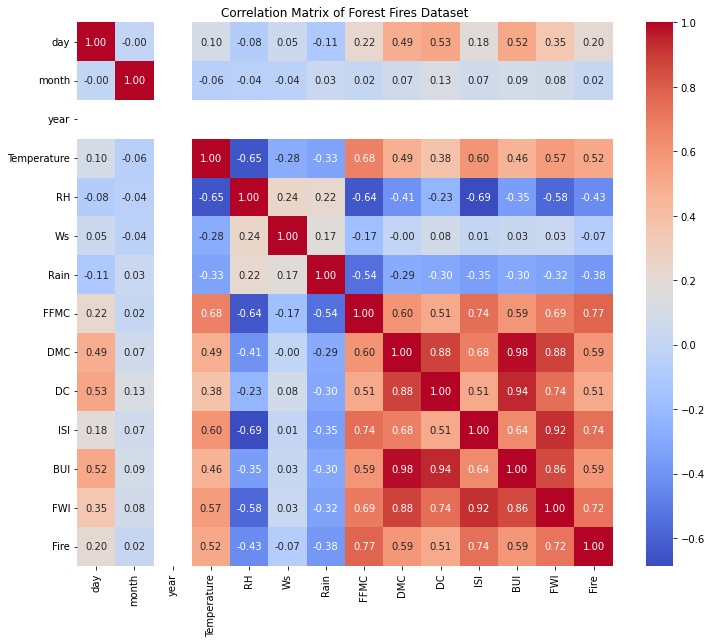

In [ ]:
eda_of_df(alg_forest_fires_df)

There are strong correlations between several of the fire weather indices like FFMC, DMC, DC, ISI, BUI, and FWI. This is expected as they are all measures related to fire risk and behavior.

Temperature shows a moderate positive correlation with some of the fire indices, which suggests higher temperatures may be associated with higher fire risk.

Rain has a negative correlation with most fire indices, indicating that more rainfall is associated with lower fire risk.

##### Plot histograms

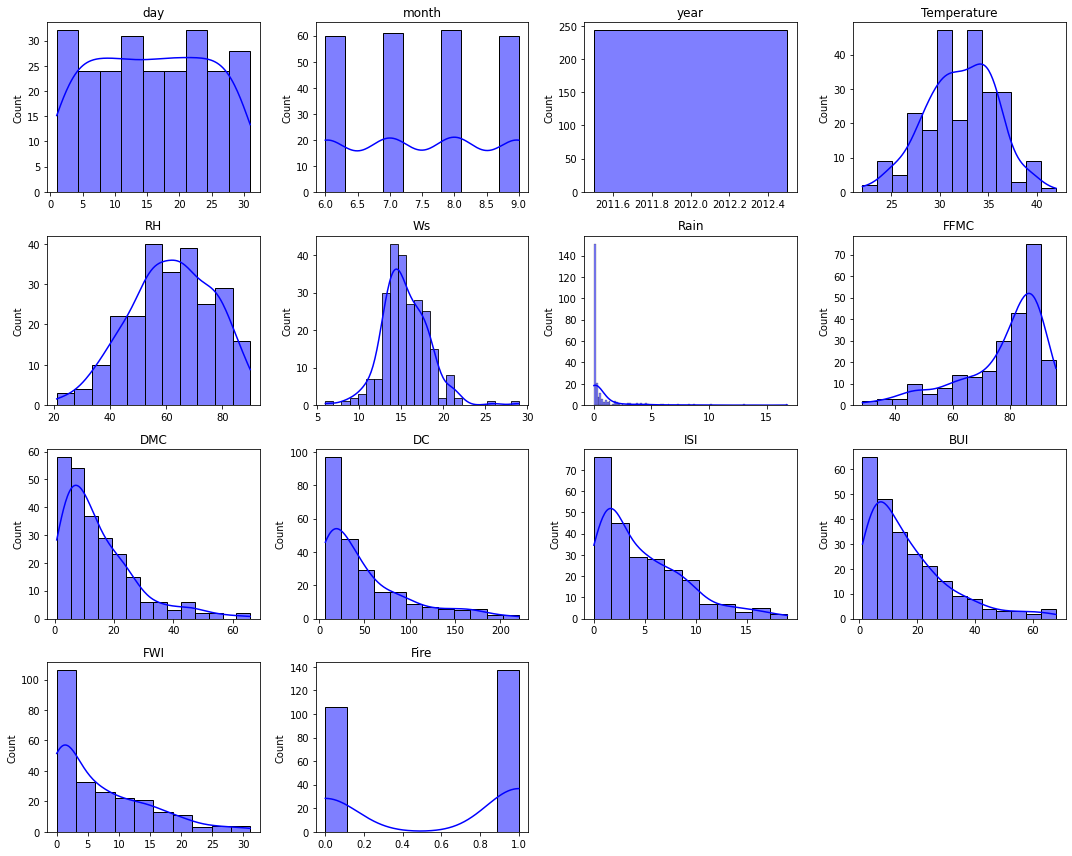

In [ ]:
plt.figure(figsize=(15, 12))
numerical_cols = alg_forest_fires_df.select_dtypes(include=[np.number]).columns.tolist()
for i, col in enumerate(numerical_cols):
    plt.subplot(4, 4, i+1)
    sns.histplot(alg_forest_fires_df[col], kde=True, color="blue")
    plt.title(col)
    plt.xlabel("")
    plt.tight_layout()
plt.show()

Variables like Temperature, RH, and Ws show relatively normal distributions.

Rain is heavily skewed towards lower values, indicating most days have little to no rainfall.

Fire indices (FFMC, DMC, DC, ISI, BUI, FWI) display varied distributions, some skewed and others more uniform, reflecting different aspects of fire risk conditions.

##### Scatter plots: FWI vs Key variables

In [ ]:
key_vars = ["Temperature", "RH", "Rain", "DMC", "DC"]

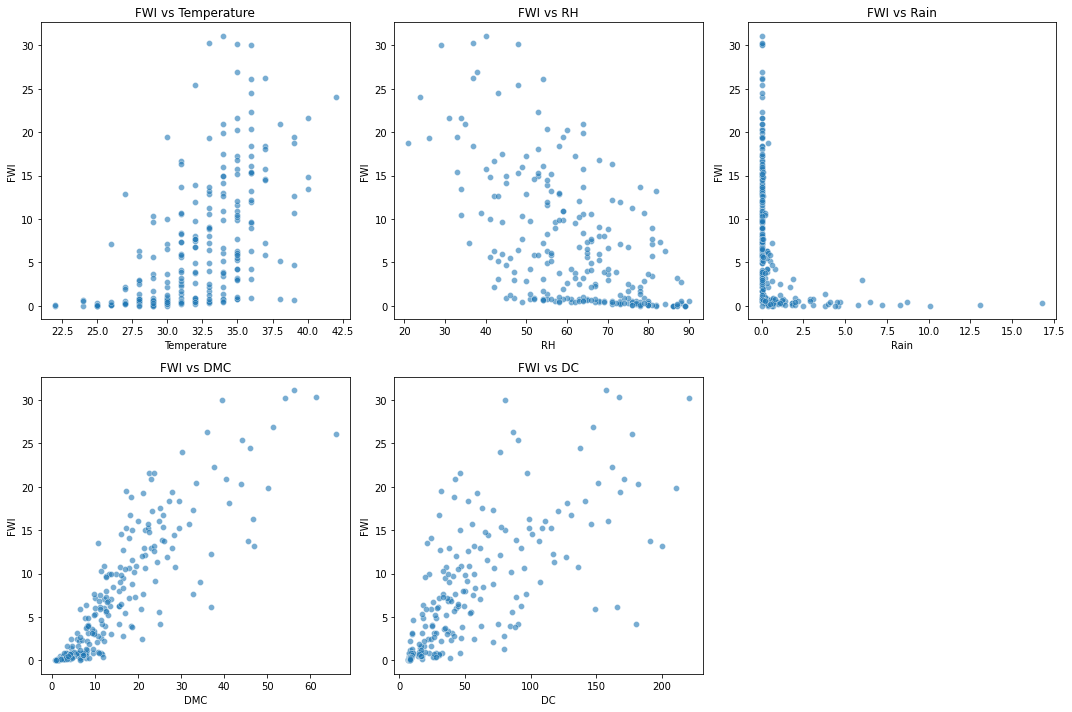

In [ ]:
plt.figure(figsize=(15, 10))
for i, key_var in enumerate(key_vars):
    plt.subplot(2, 3, i+1)
    sns.scatterplot(x=alg_forest_fires_df[key_var], y=alg_forest_fires_df["FWI"], alpha=0.6)
    plt.title(f"FWI vs {key_var}")
    plt.xlabel(key_var)
    plt.ylabel("FWI")
plt.tight_layout()
plt.show()

FWI vs Temperature: There's a positive trend indicating that higher temperatures may be associated with higher FWI values.

FWI vs RH (Relative Humidity): Shows a negative trend, suggesting that lower humidity is associated with higher FWI values.

FWI vs Rain: Clearly demonstrates a negative relationship, where more rainfall is associated with lower FWI values.

FWI vs DMC (Duff Moisture Code) and FWI vs DC (Drought Code): Both show positive relationships with FWI, indicating that as the moisture and drought conditions intensify, so does the fire risk.

##### Box plots: FWI vs Key variables

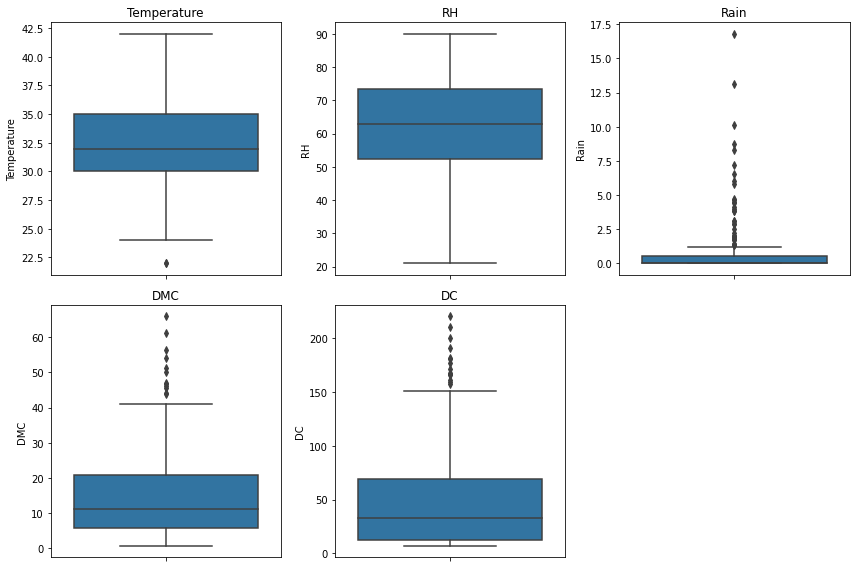

In [ ]:
plt.figure(figsize=(12, 8))
for i, key_var in enumerate(key_vars):
    plt.subplot(2, 3, i+1)
    sns.boxplot(y=alg_forest_fires_df[key_var])
    plt.title(key_var)
plt.tight_layout()
plt.show()

Temperature and RH (Relative Humidity) show a few outliers, but generally, the data points are clustered around the median.

Rain: Most of the data points are at lower values with several outliers indicating days with significant rainfall.

DMC (Duff Moisture Code) and DC (Drought Code): Both show a wide range of values with some outliers, indicating days with exceptionally high moisture and drought conditions.

##### Outlier Detection

In [ ]:
iso_forest = IsolationForest(contamination=0.1)
alg_forest_fires_df["outlier"] = iso_forest.fit_predict(alg_forest_fires_df[numerical_cols])

# Displaying the outliers
outliers = alg_forest_fires_df[alg_forest_fires_df["outlier"] == -1]
print(f"Number of outliers detected: {outliers.shape[0]}")
print(outliers.head())

Number of outliers detected: 25
    day  month  year  Temperature  RH  Ws  Rain  FFMC   DMC     DC  ISI   BUI  \
2     3      6  2012           26  82  22  13.1  47.1   2.5    7.1  0.3   2.7   
3     4      6  2012           25  89  13   2.5  28.6   1.3    6.9  0.0   1.7   
28   29      6  2012           32  47  13   0.3  79.9  18.4   84.4  2.2  23.8   
86   26      8  2012           31  78  18   0.0  85.8  45.6  190.6  4.7  57.1   
87   27      8  2012           33  82  21   0.0  84.9  47.0  200.2  4.4  59.3   

     FWI  Fire  outlier  
2    0.1     0       -1  
3    0.0     0       -1  
28   3.9     0       -1  
86  13.7     1       -1  
87  13.2     1       -1  


/home/mhs42/.local/lib/python3.10/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(


The Isolation Forest algorithm detected 25 outliers in the dataset.

##### Principal Component Analysis

In [ ]:
# Standardizing the data
scaler = StandardScaler()
X_scaled = scaler.fit_transform(alg_forest_fires_df[numerical_cols])

# Applying PCA
pca = PCA(n_components=2)  # reduce to 2 dimensions for visualization
X_pca = pca.fit_transform(X_scaled)

# Explained variance ratio
explained_variance = pca.explained_variance_ratio_
print(f"Explained variance by each component: {explained_variance}")
print(f"Total variance explained: {sum(explained_variance)}")

# Adding PCA components to the dataframe for clustering
alg_forest_fires_df["PCA1"] = X_pca[:, 0]
alg_forest_fires_df["PCA2"] = X_pca[:, 1]

Explained variance by each component: [0.49831101 0.1374371 ]
Total variance explained: 0.6357481144858488


The Principal Component Analysis (PCA) reduced the dataset to two principal components with the following explained variance:

First Component: 49.83%

Second Component: 13.74%

The total variance explained by these two components is approximately 63.57%.

##### K-Means clustering

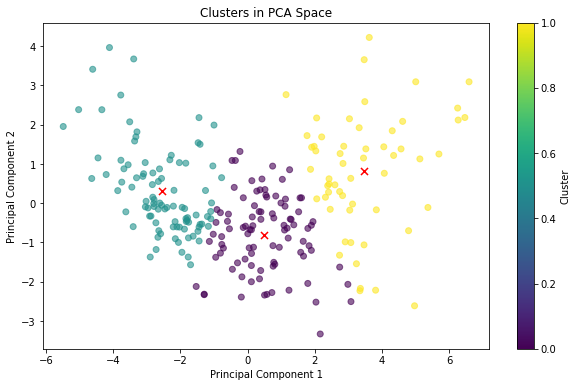

In [ ]:
kmeans = KMeans(n_clusters=3, random_state=42)
alg_forest_fires_df["cluster"] = kmeans.fit_predict(alg_forest_fires_df[["PCA1", "PCA2"]])

# Plotting the clusters
plt.figure(figsize=(10, 6))
plt.scatter(alg_forest_fires_df["PCA1"], alg_forest_fires_df["PCA2"], c=alg_forest_fires_df["cluster"], cmap="viridis", alpha=0.6)
centroids = kmeans.cluster_centers_
plt.scatter(centroids[:, 0], centroids[:, 1], c="red", s=50, marker="x")  # mark centroids
plt.title("Clusters in PCA Space")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.colorbar(label="Cluster")
plt.show()

The clusters are well-separated in the PCA space, indicating distinct groups within the data.

The red 'X' marks represent the centroids of each cluster, providing a reference point for the central location of each group.

##### Mean Shift clustering

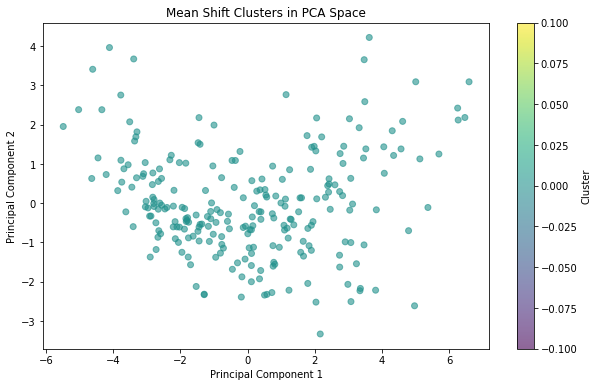

In [ ]:
mean_shift = MeanShift()
alg_forest_fires_df["mean_shift_cluster"] = mean_shift.fit_predict(alg_forest_fires_df[["PCA1", "PCA2"]])

# Plotting the Mean Shift clusters
plt.figure(figsize=(10, 6))
plt.scatter(alg_forest_fires_df["PCA1"], alg_forest_fires_df["PCA2"], c=alg_forest_fires_df["mean_shift_cluster"], cmap="viridis", alpha=0.6)
plt.title("Mean Shift Clusters in PCA Space")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.colorbar(label="Cluster")
plt.show()

Mean Shift clustering has identified a different number of clusters compared to K-Means, which can be seen in the color variation and distribution.

##### BIRCH clustering

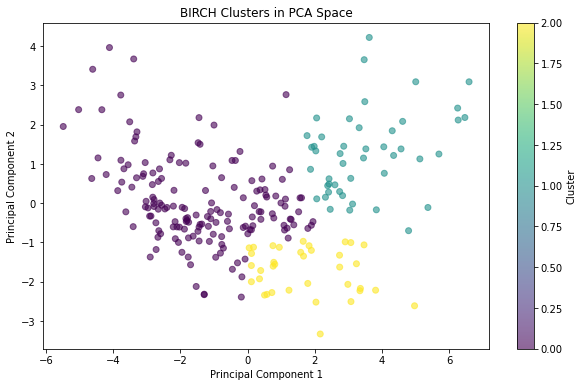

In [ ]:
birch = Birch(n_clusters=3)
alg_forest_fires_df["birch_cluster"] = birch.fit_predict(alg_forest_fires_df[["PCA1", "PCA2"]])

# Plotting the BIRCH clusters
plt.figure(figsize=(10, 6))
plt.scatter(alg_forest_fires_df["PCA1"], alg_forest_fires_df["PCA2"], c=alg_forest_fires_df["birch_cluster"], cmap="viridis", alpha=0.6)
plt.title("BIRCH Clusters in PCA Space")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.colorbar(label="Cluster")
plt.show()

Similar to K-Means, BIRCH has also identified three clusters, showing a distribution pattern that closely resembles the K-Means results.

##### DBSCAN

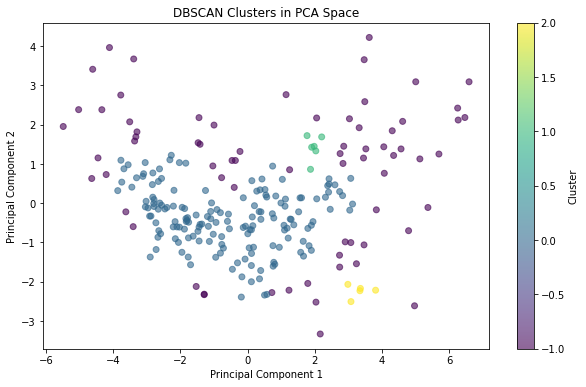

In [ ]:
epsilon = 0.5  # typical starting value
min_samples = 5  # minimum cluster size

# Applying DBSCAN
dbscan = DBSCAN(eps=epsilon, min_samples=min_samples)
alg_forest_fires_df["dbscan_cluster"] = dbscan.fit_predict(alg_forest_fires_df[["PCA1", "PCA2"]])

# Plotting the DBSCAN clusters
plt.figure(figsize=(10, 6))
plt.scatter(alg_forest_fires_df["PCA1"], alg_forest_fires_df["PCA2"], c=alg_forest_fires_df["dbscan_cluster"], cmap="viridis", alpha=0.6)
plt.title("DBSCAN Clusters in PCA Space")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.colorbar(label="Cluster")
plt.show()

DBSCAN has identified several clusters and noise points (typically shown in a different color). This method is effective in finding high-density areas and distinguishing them from sparse areas, which are considered noise.

##### Fuzzy c-means clustering

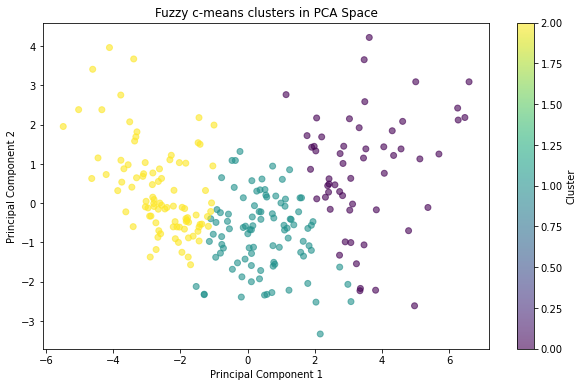

In [ ]:
clusters = 3    # number of clusters

# Extracting data for clustering
alldata = np.vstack((alg_forest_fires_df["PCA1"], alg_forest_fires_df["PCA2"]))

# Fuzzy c-means clustering
cntr, u, u0, d, jm, p, fpc = fuzz.cluster.cmeans(alldata, c=clusters, m=2, error=0.005, maxiter=1000, init=None)

# Assigning clusters
cluster_membership = np.argmax(u, axis=0)
alg_forest_fires_df["fuzzy_c_means_cluster"] = cluster_membership

# Plotting the fuzzy c-means clusters
plt.figure(figsize=(10, 6))
plt.scatter(alg_forest_fires_df["PCA1"], alg_forest_fires_df["PCA2"], c=alg_forest_fires_df["fuzzy_c_means_cluster"], cmap="viridis", alpha=0.6)
plt.title("Fuzzy c-means clusters in PCA Space")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.colorbar(label="Cluster")
plt.show()

Fuzzy C-Means clustering has assigned each data point a degree of belonging to each cluster, rather than forcing a hard assignment. This results in a more nuanced view of the data groupings.

The color gradient represents the membership strength to the clusters, providing a visual representation of the uncertainty in cluster membership.

### Fuzzy Rule Based System for Algerian Forest Fires Dataset

In [ ]:
alg_FS = sf.FuzzySystem(show_banner=False)

##### Define all linguistic variables.

In [ ]:
alg_FS.add_linguistic_variable("Temp", sf.LinguisticVariable(
    [
        sf.TriangleFuzzySet(22, 24, 26, term="Low"),
        sf.TriangleFuzzySet(26, 28, 30, term="LowMedium"),
        sf.TriangleFuzzySet(30, 32, 34, term="Medium"),
        sf.TriangleFuzzySet(34, 36, 38, term="MediumHigh"),
        sf.TriangleFuzzySet(38, 40, 42, term="High")
    ],
    concept="Temperature", universe_of_discourse=[22, 42]
))

alg_FS.add_linguistic_variable("RH", sf.LinguisticVariable(
    [
        sf.TriangleFuzzySet(21.0, 27.9, 34.8, term="Low"),
        sf.TriangleFuzzySet(34.8, 41.7, 48.6, term="LowMedium"),
        sf.TriangleFuzzySet(48.6, 55.5, 62.4, term="Medium"),
        sf.TriangleFuzzySet(62.4, 69.3, 76.2, term="MediumHigh"),
        sf.TriangleFuzzySet(76.2, 83.1, 90.0, term="High")
    ],
    concept="Relative Humidity", universe_of_discourse=[21.0, 90.0]
))

#alg_FS.add_linguistic_variable("Ws", sf.LinguisticVariable(
#    [
#        sf.TriangleFuzzySet(6.0, 8.3, 10.6, term="Low"),
#        sf.TriangleFuzzySet(10.6, 12.9, 15.2, term="LowMedium"),
#        sf.TriangleFuzzySet(15.2, 17.5, 19.8, term="Medium"),
#        sf.TriangleFuzzySet(19.8, 22.1, 24.4, term="MediumHigh"),
#        sf.TriangleFuzzySet(24.4, 26.7, 29.0, term="High")
#    ],
#    concept="Wind Speed", universe_of_discourse=[6.0, 29.0]
#))

alg_FS.add_linguistic_variable("Rain", sf.LinguisticVariable(
    [
        sf.TriangleFuzzySet(0.0, 1.68, 3.36, term="Low"),
        sf.TriangleFuzzySet(3.36, 5.04, 6.72, term="LowMedium"),
        sf.TriangleFuzzySet(6.72, 8.4, 10.08, term="Medium"),
        sf.TriangleFuzzySet(10.08, 11.76, 13.44, term="MediumHigh"),
        sf.TriangleFuzzySet(13.44, 15.12, 16.8, term="High")
    ],
    concept="Outside Rain", universe_of_discourse=[0.0, 16.8]
))

alg_FS.add_linguistic_variable("FFMC", sf.LinguisticVariable(
    [
        sf.TriangleFuzzySet(28.6, 35.34, 42.08, term="Low"),
        sf.TriangleFuzzySet(42.08, 48.82, 55.56, term="LowMedium"),
        sf.TriangleFuzzySet(55.56, 62.3, 69.04, term="Medium"),
        sf.TriangleFuzzySet(69.04, 75.78, 82.52, term="MediumHigh"),
        sf.TriangleFuzzySet(82.52, 89.26, 96.0, term="High")
    ],
    concept="Fine Fuel Moisture Code index", universe_of_discourse=[28.6, 96.0]
))

alg_FS.add_linguistic_variable("DMC", sf.LinguisticVariable(
    [
        sf.TriangleFuzzySet(0.7, 7.22, 13.74, term="Low"),
        sf.TriangleFuzzySet(13.74, 20.26, 26.78, term="LowMedium"),
        sf.TriangleFuzzySet(26.78, 33.3, 39.82, term="Medium"),
        sf.TriangleFuzzySet(39.82, 46.34, 52.86, term="MediumHigh"),
        sf.TriangleFuzzySet(52.86, 59.38, 65.9, term="High")
    ],
    concept="Duff Moisture Code index", universe_of_discourse=[0.7, 65.9]
))

alg_FS.add_linguistic_variable("DC", sf.LinguisticVariable(
    [
        sf.TriangleFuzzySet(6.9, 28.25, 49.6, term="Low"),
        sf.TriangleFuzzySet(49.6, 70.95, 92.3, term="LowMedium"),
        sf.TriangleFuzzySet(92.3, 113.65, 135, term="Medium"),
        sf.TriangleFuzzySet(135, 156.35, 177.7, term="MediumHigh"),
        sf.TriangleFuzzySet(177.7, 199.05, 220.4, term="High")
    ],
    concept="Drought Code index", universe_of_discourse=[6.9, 220.4]
))

alg_FS.add_linguistic_variable("ISI", sf.LinguisticVariable(
    [
        sf.TriangleFuzzySet(0.0, 1.9, 3.8, term="Low"),
        sf.TriangleFuzzySet(3.8, 5.7, 7.6, term="LowMedium"),
        sf.TriangleFuzzySet(7.6, 9.5, 11.4, term="Medium"),
        sf.TriangleFuzzySet(11.4, 13.3, 15.2, term="MediumHigh"),
        sf.TriangleFuzzySet(15.2, 17.1, 19.0, term="High")
    ],
    concept="Initial Spread Index", universe_of_discourse=[0.0, 19.0]
))

alg_FS.add_linguistic_variable("BUI", sf.LinguisticVariable(
    [
        sf.TriangleFuzzySet(1.1, 7.79, 14.48, term="Low"),
        sf.TriangleFuzzySet(14.48, 21.17, 27.86, term="LowMedium"),
        sf.TriangleFuzzySet(27.86, 34.55, 41.24, term="Medium"),
        sf.TriangleFuzzySet(41.24, 47.93, 54.62, term="MediumHigh"),
        sf.TriangleFuzzySet(54.62, 61.31, 68.0, term="High")
    ],
    concept="Buildup Index", universe_of_discourse=[1.1, 68.0]
))

alg_FS.add_linguistic_variable("FWI", sf.LinguisticVariable(
    [
        sf.TriangleFuzzySet(0.0, 3.11, 6.22, term="Low"),
        sf.TriangleFuzzySet(6.22, 9.33, 12.44, term="LowMedium"),
        sf.TriangleFuzzySet(12.44, 15.55, 18.66, term="Medium"),
        sf.TriangleFuzzySet(18.66, 21.77, 24.88, term="MediumHigh"),
        sf.TriangleFuzzySet(24.88, 27.99, 31.1, term="High")
    ],
    concept="Fire Weather Index", universe_of_discourse=[0.0, 31.1]
))

# alg_FS.add_linguistic_variable("Fire", sf.LinguisticVariable(
#     [
#         sf.TriangleFuzzySet(0.0, 0.1, 0.2, term="Low"),
#         sf.TriangleFuzzySet(0.2, 0.3, 0.4, term="LowMedium"),
#         sf.TriangleFuzzySet(0.4, 0.5, 0.6, term="Medium"),
#         sf.TriangleFuzzySet(0.6, 0.7, 0.8, term="MediumHigh"),
#         sf.TriangleFuzzySet(0.8, 0.9, 1.0, term="High")
#     ],
#     concept="Chance of Fire", universe_of_discourse=[0.0, 1.0]
# ))

##### Define consequents

In [ ]:
alg_FS.set_crisp_output_value("Low", 0.05)
alg_FS.set_crisp_output_value("LowMedium", 0.2)
alg_FS.set_crisp_output_value("Medium", 0.5)
alg_FS.set_crisp_output_value("MediumHigh", 0.8)
alg_FS.set_crisp_output_value("High", 0.95)

 * Detected Sugeno model type


##### Define fuzzy rules

In [ ]:
alg_FS.add_rules(
    [
        "IF (Temp IS High) AND (RH IS Low) AND (Rain IS Low) AND (FFMC IS High) AND (DMC IS High) AND (DC IS High) AND (ISI IS High) AND (BUI IS High) AND (FWI IS High) THEN (FireChance IS High)",
        "IF (Temp IS High) AND (RH IS Low) AND (Rain IS Low) AND (FFMC IS Low) AND (DMC IS Low) AND (DC IS Low) AND (ISI IS Low) AND (BUI IS Low) AND (FWI IS Low) THEN (FireChance IS Medium)",
        "IF (Temp IS Low) AND (RH IS Low) AND (Rain IS Low) AND (FFMC IS High) AND (DMC IS Low) AND (DC IS Low) AND (ISI IS Low) AND (BUI IS Low) AND (FWI IS Low) THEN (FireChance IS Medium)",
        "IF (Temp IS Low) AND (RH IS Low) AND (Rain IS Low) AND (FFMC IS Low) AND (DMC IS High) AND (DC IS Low) AND (ISI IS Low) AND (BUI IS Low) AND (FWI IS Low) THEN (FireChance IS Medium)",
        "IF (Temp IS Low) AND (RH IS Low) AND (Rain IS Low) AND (FFMC IS Low) AND (DMC IS Low) AND (DC IS High) AND (ISI IS Low) AND (BUI IS Low) AND (FWI IS Low) THEN (FireChance IS Medium)",
        "IF (Temp IS Low) AND (RH IS Low) AND (Rain IS Low) AND (FFMC IS Low) AND (DMC IS Low) AND (DC IS Low) AND (ISI IS High) AND (BUI IS Low) AND (FWI IS Low) THEN (FireChance IS Medium)",
        "IF (Temp IS Low) AND (RH IS Low) AND (Rain IS Low) AND (FFMC IS Low) AND (DMC IS Low) AND (DC IS Low) AND (ISI IS Low) AND (BUI IS High) AND (FWI IS Low) THEN (FireChance IS Medium)",
        "IF (Temp IS Low) AND (RH IS Low) AND (Rain IS Low) AND (FFMC IS Low) AND (DMC IS Low) AND (DC IS Low) AND (ISI IS Low) AND (BUI IS Low) AND (FWI IS High) THEN (FireChance IS Medium)",
        "IF (Temp IS High) AND (RH IS Low) AND (Rain IS Low) AND (FFMC IS High) AND (DMC IS Low) AND (DC IS Low) AND (ISI IS Low) AND (BUI IS Low) AND (FWI IS Low) THEN (FireChance IS Medium)",
        "IF (Temp IS High) AND (RH IS Low) AND (Rain IS Low) AND (FFMC IS Low) AND (DMC IS High) AND (DC IS Low) AND (ISI IS Low) AND (BUI IS Low) AND (FWI IS Low) THEN (FireChance IS Medium)",
        "IF (Temp IS High) AND (RH IS Low) AND (Rain IS Low) AND (FFMC IS Low) AND (DMC IS Low) AND (DC IS High) AND (ISI IS Low) AND (BUI IS Low) AND (FWI IS Low) THEN (FireChance IS Medium)",
        "IF (Temp IS High) AND (RH IS Low) AND (Rain IS Low) AND (FFMC IS Low) AND (DMC IS Low) AND (DC IS Low) AND (ISI IS High) AND (BUI IS Low) AND (FWI IS Low) THEN (FireChance IS Medium)",
        "IF (Temp IS High) AND (RH IS Low) AND (Rain IS Low) AND (FFMC IS Low) AND (DMC IS Low) AND (DC IS Low) AND (ISI IS Low) AND (BUI IS High) AND (FWI IS Low) THEN (FireChance IS Medium)",
        "IF (Temp IS High) AND (RH IS Low) AND (Rain IS Low) AND (FFMC IS Low) AND (DMC IS Low) AND (DC IS Low) AND (ISI IS Low) AND (BUI IS Low) AND (FWI IS High) THEN (FireChance IS Medium)",
        "IF (Temp IS Low) AND (RH IS Low) AND (Rain IS Low) AND (FFMC IS High) AND (DMC IS High) AND (DC IS Low) AND (ISI IS Low) AND (BUI IS Low) AND (FWI IS Low) THEN (FireChance IS Medium)",
        "IF (Temp IS Low) AND (RH IS Low) AND (Rain IS Low) AND (FFMC IS High) AND (DMC IS Low) AND (DC IS High) AND (ISI IS Low) AND (BUI IS Low) AND (FWI IS Low) THEN (FireChance IS Medium)",
        "IF (Temp IS Low) AND (RH IS Low) AND (Rain IS Low) AND (FFMC IS High) AND (DMC IS Low) AND (DC IS Low) AND (ISI IS High) AND (BUI IS Low) AND (FWI IS Low) THEN (FireChance IS Medium)",
        "IF (Temp IS Low) AND (RH IS Low) AND (Rain IS Low) AND (FFMC IS High) AND (DMC IS Low) AND (DC IS Low) AND (ISI IS Low) AND (BUI IS High) AND (FWI IS Low) THEN (FireChance IS Medium)",
        "IF (Temp IS Low) AND (RH IS Low) AND (Rain IS Low) AND (FFMC IS High) AND (DMC IS Low) AND (DC IS Low) AND (ISI IS Low) AND (BUI IS Low) AND (FWI IS High) THEN (FireChance IS Medium)",
        "IF (Temp IS Low) AND (RH IS Low) AND (Rain IS Low) AND (FFMC IS Low) AND (DMC IS High) AND (DC IS High) AND (ISI IS Low) AND (BUI IS Low) AND (FWI IS Low) THEN (FireChance IS Medium)",
        "IF (Temp IS Low) AND (RH IS Low) AND (Rain IS Low) AND (FFMC IS Low) AND (DMC IS High) AND (DC IS Low) AND (ISI IS High) AND (BUI IS Low) AND (FWI IS Low) THEN (FireChance IS Medium)",
        "IF (Temp IS Low) AND (RH IS Low) AND (Rain IS Low) AND (FFMC IS Low) AND (DMC IS High) AND (DC IS Low) AND (ISI IS Low) AND (BUI IS High) AND (FWI IS Low) THEN (FireChance IS Medium)",
        "IF (Temp IS Low) AND (RH IS Low) AND (Rain IS Low) AND (FFMC IS Low) AND (DMC IS High) AND (DC IS Low) AND (ISI IS Low) AND (BUI IS Low) AND (FWI IS High) THEN (FireChance IS Medium)",
        "IF (Temp IS Low) AND (RH IS Low) AND (Rain IS Low) AND (FFMC IS Low) AND (DMC IS Low) AND (DC IS High) AND (ISI IS High) AND (BUI IS Low) AND (FWI IS Low) THEN (FireChance IS Medium)",
        "IF (Temp IS Low) AND (RH IS Low) AND (Rain IS Low) AND (FFMC IS Low) AND (DMC IS Low) AND (DC IS High) AND (ISI IS Low) AND (BUI IS High) AND (FWI IS Low) THEN (FireChance IS Medium)",
        "IF (Temp IS Low) AND (RH IS Low) AND (Rain IS Low) AND (FFMC IS Low) AND (DMC IS Low) AND (DC IS High) AND (ISI IS Low) AND (BUI IS Low) AND (FWI IS High) THEN (FireChance IS Medium)",
        "IF (Temp IS Low) AND (RH IS Low) AND (Rain IS Low) AND (FFMC IS Low) AND (DMC IS Low) AND (DC IS Low) AND (ISI IS High) AND (BUI IS High) AND (FWI IS Low) THEN (FireChance IS Medium)",
        "IF (Temp IS Low) AND (RH IS Low) AND (Rain IS Low) AND (FFMC IS Low) AND (DMC IS Low) AND (DC IS Low) AND (ISI IS High) AND (BUI IS Low) AND (FWI IS High) THEN (FireChance IS Medium)",
        "IF (Temp IS Low) AND (RH IS Low) AND (Rain IS Low) AND (FFMC IS Low) AND (DMC IS Low) AND (DC IS Low) AND (ISI IS Low) AND (BUI IS High) AND (FWI IS High) THEN (FireChance IS Medium)",
        "IF (Temp IS High) AND (RH IS Low) AND (Rain IS Low) AND (FFMC IS High) AND (DMC IS High) AND (DC IS Low) AND (ISI IS Low) AND (BUI IS Low) AND (FWI IS Low) THEN (FireChance IS MediumHigh)",
        "IF (Temp IS High) AND (RH IS Low) AND (Rain IS Low) AND (FFMC IS High) AND (DMC IS Low) AND (DC IS High) AND (ISI IS Low) AND (BUI IS Low) AND (FWI IS Low) THEN (FireChance IS MediumHigh)",
        "IF (Temp IS High) AND (RH IS Low) AND (Rain IS Low) AND (FFMC IS High) AND (DMC IS Low) AND (DC IS Low) AND (ISI IS High) AND (BUI IS Low) AND (FWI IS Low) THEN (FireChance IS MediumHigh)",
        "IF (Temp IS High) AND (RH IS Low) AND (Rain IS Low) AND (FFMC IS High) AND (DMC IS Low) AND (DC IS Low) AND (ISI IS Low) AND (BUI IS High) AND (FWI IS Low) THEN (FireChance IS MediumHigh)",
        "IF (Temp IS High) AND (RH IS Low) AND (Rain IS Low) AND (FFMC IS High) AND (DMC IS Low) AND (DC IS Low) AND (ISI IS Low) AND (BUI IS Low) AND (FWI IS High) THEN (FireChance IS MediumHigh)",
        "IF (Temp IS High) AND (RH IS Low) AND (Rain IS Low) AND (FFMC IS Low) AND (DMC IS High) AND (DC IS High) AND (ISI IS Low) AND (BUI IS Low) AND (FWI IS Low) THEN (FireChance IS MediumHigh)",
        "IF (Temp IS High) AND (RH IS Low) AND (Rain IS Low) AND (FFMC IS Low) AND (DMC IS High) AND (DC IS Low) AND (ISI IS High) AND (BUI IS Low) AND (FWI IS Low) THEN (FireChance IS MediumHigh)",
        "IF (Temp IS High) AND (RH IS Low) AND (Rain IS Low) AND (FFMC IS Low) AND (DMC IS High) AND (DC IS Low) AND (ISI IS Low) AND (BUI IS High) AND (FWI IS Low) THEN (FireChance IS MediumHigh)",
        "IF (Temp IS High) AND (RH IS Low) AND (Rain IS Low) AND (FFMC IS Low) AND (DMC IS High) AND (DC IS Low) AND (ISI IS Low) AND (BUI IS Low) AND (FWI IS High) THEN (FireChance IS MediumHigh)",
        "IF (Temp IS High) AND (RH IS Low) AND (Rain IS Low) AND (FFMC IS Low) AND (DMC IS Low) AND (DC IS High) AND (ISI IS High) AND (BUI IS Low) AND (FWI IS Low) THEN (FireChance IS MediumHigh)",
        "IF (Temp IS High) AND (RH IS Low) AND (Rain IS Low) AND (FFMC IS Low) AND (DMC IS Low) AND (DC IS High) AND (ISI IS Low) AND (BUI IS High) AND (FWI IS Low) THEN (FireChance IS MediumHigh)",
        "IF (Temp IS High) AND (RH IS Low) AND (Rain IS Low) AND (FFMC IS Low) AND (DMC IS Low) AND (DC IS High) AND (ISI IS Low) AND (BUI IS Low) AND (FWI IS High) THEN (FireChance IS MediumHigh)",
        "IF (Temp IS High) AND (RH IS Low) AND (Rain IS Low) AND (FFMC IS Low) AND (DMC IS Low) AND (DC IS Low) AND (ISI IS High) AND (BUI IS High) AND (FWI IS Low) THEN (FireChance IS MediumHigh)",
        "IF (Temp IS High) AND (RH IS Low) AND (Rain IS Low) AND (FFMC IS Low) AND (DMC IS Low) AND (DC IS Low) AND (ISI IS High) AND (BUI IS Low) AND (FWI IS High) THEN (FireChance IS MediumHigh)",
        "IF (Temp IS High) AND (RH IS Low) AND (Rain IS Low) AND (FFMC IS Low) AND (DMC IS Low) AND (DC IS Low) AND (ISI IS Low) AND (BUI IS High) AND (FWI IS High) THEN (FireChance IS MediumHigh)",
        "IF (Temp IS Low) AND (RH IS Low) AND (Rain IS Low) AND (FFMC IS High) AND (DMC IS High) AND (DC IS High) AND (ISI IS Low) AND (BUI IS Low) AND (FWI IS Low) THEN (FireChance IS MediumHigh)",
        "IF (Temp IS Low) AND (RH IS Low) AND (Rain IS Low) AND (FFMC IS High) AND (DMC IS High) AND (DC IS Low) AND (ISI IS High) AND (BUI IS Low) AND (FWI IS Low) THEN (FireChance IS MediumHigh)",
        "IF (Temp IS Low) AND (RH IS Low) AND (Rain IS Low) AND (FFMC IS High) AND (DMC IS High) AND (DC IS Low) AND (ISI IS Low) AND (BUI IS High) AND (FWI IS Low) THEN (FireChance IS MediumHigh)",
        "IF (Temp IS Low) AND (RH IS Low) AND (Rain IS Low) AND (FFMC IS High) AND (DMC IS High) AND (DC IS Low) AND (ISI IS Low) AND (BUI IS Low) AND (FWI IS High) THEN (FireChance IS MediumHigh)",
        "IF (Temp IS Low) AND (RH IS Low) AND (Rain IS Low) AND (FFMC IS High) AND (DMC IS Low) AND (DC IS High) AND (ISI IS High) AND (BUI IS Low) AND (FWI IS Low) THEN (FireChance IS MediumHigh)",
        "IF (Temp IS Low) AND (RH IS Low) AND (Rain IS Low) AND (FFMC IS High) AND (DMC IS Low) AND (DC IS High) AND (ISI IS Low) AND (BUI IS High) AND (FWI IS Low) THEN (FireChance IS MediumHigh)",
        "IF (Temp IS Low) AND (RH IS Low) AND (Rain IS Low) AND (FFMC IS High) AND (DMC IS Low) AND (DC IS High) AND (ISI IS Low) AND (BUI IS Low) AND (FWI IS High) THEN (FireChance IS MediumHigh)",
        "IF (Temp IS Low) AND (RH IS Low) AND (Rain IS Low) AND (FFMC IS High) AND (DMC IS Low) AND (DC IS Low) AND (ISI IS High) AND (BUI IS High) AND (FWI IS Low) THEN (FireChance IS MediumHigh)",
        "IF (Temp IS Low) AND (RH IS Low) AND (Rain IS Low) AND (FFMC IS High) AND (DMC IS Low) AND (DC IS Low) AND (ISI IS High) AND (BUI IS Low) AND (FWI IS High) THEN (FireChance IS MediumHigh)",
        "IF (Temp IS Low) AND (RH IS Low) AND (Rain IS Low) AND (FFMC IS High) AND (DMC IS Low) AND (DC IS Low) AND (ISI IS Low) AND (BUI IS High) AND (FWI IS High) THEN (FireChance IS MediumHigh)",
        "IF (Temp IS Low) AND (RH IS Low) AND (Rain IS Low) AND (FFMC IS Low) AND (DMC IS High) AND (DC IS High) AND (ISI IS High) AND (BUI IS Low) AND (FWI IS Low) THEN (FireChance IS MediumHigh)",
        "IF (Temp IS Low) AND (RH IS Low) AND (Rain IS Low) AND (FFMC IS Low) AND (DMC IS High) AND (DC IS High) AND (ISI IS Low) AND (BUI IS High) AND (FWI IS Low) THEN (FireChance IS MediumHigh)",
        "IF (Temp IS Low) AND (RH IS Low) AND (Rain IS Low) AND (FFMC IS Low) AND (DMC IS High) AND (DC IS High) AND (ISI IS Low) AND (BUI IS Low) AND (FWI IS High) THEN (FireChance IS MediumHigh)",
        "IF (Temp IS Low) AND (RH IS Low) AND (Rain IS Low) AND (FFMC IS Low) AND (DMC IS High) AND (DC IS Low) AND (ISI IS High) AND (BUI IS High) AND (FWI IS Low) THEN (FireChance IS MediumHigh)",
        "IF (Temp IS Low) AND (RH IS Low) AND (Rain IS Low) AND (FFMC IS Low) AND (DMC IS High) AND (DC IS Low) AND (ISI IS High) AND (BUI IS Low) AND (FWI IS High) THEN (FireChance IS MediumHigh)",
        "IF (Temp IS Low) AND (RH IS Low) AND (Rain IS Low) AND (FFMC IS Low) AND (DMC IS High) AND (DC IS Low) AND (ISI IS Low) AND (BUI IS High) AND (FWI IS High) THEN (FireChance IS MediumHigh)",
        "IF (Temp IS High) AND (RH IS Low) AND (Rain IS Low) AND (FFMC IS High) AND (DMC IS High) AND (DC IS High) AND (ISI IS Low) AND (BUI IS Low) AND (FWI IS Low) THEN (FireChance IS MediumHigh)",
        "IF (Temp IS High) AND (RH IS Low) AND (Rain IS Low) AND (FFMC IS High) AND (DMC IS High) AND (DC IS Low) AND (ISI IS High) AND (BUI IS Low) AND (FWI IS Low) THEN (FireChance IS MediumHigh)",
        "IF (Temp IS High) AND (RH IS Low) AND (Rain IS Low) AND (FFMC IS High) AND (DMC IS High) AND (DC IS Low) AND (ISI IS Low) AND (BUI IS High) AND (FWI IS Low) THEN (FireChance IS MediumHigh)",
        "IF (Temp IS High) AND (RH IS Low) AND (Rain IS Low) AND (FFMC IS High) AND (DMC IS High) AND (DC IS Low) AND (ISI IS Low) AND (BUI IS Low) AND (FWI IS High) THEN (FireChance IS MediumHigh)",
        "IF (Temp IS High) AND (RH IS Low) AND (Rain IS Low) AND (FFMC IS High) AND (DMC IS Low) AND (DC IS High) AND (ISI IS High) AND (BUI IS Low) AND (FWI IS Low) THEN (FireChance IS MediumHigh)",
        "IF (Temp IS High) AND (RH IS Low) AND (Rain IS Low) AND (FFMC IS High) AND (DMC IS Low) AND (DC IS High) AND (ISI IS Low) AND (BUI IS High) AND (FWI IS Low) THEN (FireChance IS MediumHigh)",
        "IF (Temp IS High) AND (RH IS Low) AND (Rain IS Low) AND (FFMC IS High) AND (DMC IS Low) AND (DC IS High) AND (ISI IS Low) AND (BUI IS Low) AND (FWI IS High) THEN (FireChance IS MediumHigh)",
        "IF (Temp IS High) AND (RH IS Low) AND (Rain IS Low) AND (FFMC IS High) AND (DMC IS Low) AND (DC IS Low) AND (ISI IS High) AND (BUI IS High) AND (FWI IS Low) THEN (FireChance IS MediumHigh)",
        "IF (Temp IS High) AND (RH IS Low) AND (Rain IS Low) AND (FFMC IS High) AND (DMC IS Low) AND (DC IS Low) AND (ISI IS High) AND (BUI IS Low) AND (FWI IS High) THEN (FireChance IS MediumHigh)",
        "IF (Temp IS High) AND (RH IS Low) AND (Rain IS Low) AND (FFMC IS High) AND (DMC IS Low) AND (DC IS Low) AND (ISI IS Low) AND (BUI IS High) AND (FWI IS High) THEN (FireChance IS MediumHigh)",
        "IF (Temp IS High) AND (RH IS Low) AND (Rain IS Low) AND (FFMC IS Low) AND (DMC IS High) AND (DC IS High) AND (ISI IS High) AND (BUI IS Low) AND (FWI IS Low) THEN (FireChance IS MediumHigh)",
        "IF (Temp IS High) AND (RH IS Low) AND (Rain IS Low) AND (FFMC IS Low) AND (DMC IS High) AND (DC IS High) AND (ISI IS Low) AND (BUI IS High) AND (FWI IS Low) THEN (FireChance IS MediumHigh)",
        "IF (Temp IS High) AND (RH IS Low) AND (Rain IS Low) AND (FFMC IS Low) AND (DMC IS High) AND (DC IS High) AND (ISI IS Low) AND (BUI IS Low) AND (FWI IS High) THEN (FireChance IS MediumHigh)",
        "IF (Temp IS High) AND (RH IS Low) AND (Rain IS Low) AND (FFMC IS Low) AND (DMC IS High) AND (DC IS Low) AND (ISI IS High) AND (BUI IS High) AND (FWI IS Low) THEN (FireChance IS MediumHigh)",
        "IF (Temp IS High) AND (RH IS Low) AND (Rain IS Low) AND (FFMC IS Low) AND (DMC IS High) AND (DC IS Low) AND (ISI IS High) AND (BUI IS Low) AND (FWI IS High) THEN (FireChance IS MediumHigh)",
        "IF (Temp IS High) AND (RH IS Low) AND (Rain IS Low) AND (FFMC IS Low) AND (DMC IS Low) AND (DC IS High) AND (ISI IS High) AND (BUI IS High) AND (FWI IS Low) THEN (FireChance IS MediumHigh)",
        "IF (Temp IS High) AND (RH IS Low) AND (Rain IS Low) AND (FFMC IS Low) AND (DMC IS Low) AND (DC IS High) AND (ISI IS High) AND (BUI IS Low) AND (FWI IS High) THEN (FireChance IS MediumHigh)",
        "IF (Temp IS High) AND (RH IS Low) AND (Rain IS Low) AND (FFMC IS Low) AND (DMC IS Low) AND (DC IS High) AND (ISI IS Low) AND (BUI IS High) AND (FWI IS High) THEN (FireChance IS MediumHigh)",
        "IF (Temp IS High) AND (RH IS Low) AND (Rain IS Low) AND (FFMC IS Low) AND (DMC IS Low) AND (DC IS Low) AND (ISI IS High) AND (BUI IS High) AND (FWI IS High) THEN (FireChance IS MediumHigh)",
        "IF (Temp IS High) AND (RH IS Low) AND (Rain IS Low) AND (FFMC IS High) AND (DMC IS High) AND (DC IS High) AND (ISI IS High) AND (BUI IS High) AND (FWI IS Low) THEN (FireChance IS High)",
        "IF (Temp IS High) AND (RH IS Low) AND (Rain IS Low) AND (FFMC IS High) AND (DMC IS High) AND (DC IS High) AND (ISI IS High) AND (BUI IS Low) AND (FWI IS High) THEN (FireChance IS High)",
        "IF (Temp IS High) AND (RH IS Low) AND (Rain IS Low) AND (FFMC IS High) AND (DMC IS Low) AND (DC IS High) AND (ISI IS High) AND (BUI IS High) AND (FWI IS High) THEN (FireChance IS High)",
        "IF (Temp IS High) AND (RH IS Low) AND (Rain IS Low) AND (FFMC IS High) AND (DMC IS High) AND (DC IS Low) AND (ISI IS High) AND (BUI IS High) AND (FWI IS High) THEN (FireChance IS High)",
        "IF (Temp IS High) AND (RH IS Low) AND (Rain IS Low) AND (FFMC IS High) AND (DMC IS High) AND (DC IS High) AND (ISI IS Low) AND (BUI IS High) AND (FWI IS High) THEN (FireChance IS High)",
        "IF (Temp IS Low) AND (RH IS Low) AND (Rain IS Low) AND (FFMC IS High) AND (DMC IS High) AND (DC IS High) AND (ISI IS High) AND (BUI IS High) AND (FWI IS High) THEN (FireChance IS High)",
        "IF (Temp IS High) AND (RH IS Low) AND (Rain IS Low) AND (FFMC IS Low) AND (DMC IS High) AND (DC IS High) AND (ISI IS High) AND (BUI IS High) AND (FWI IS High) THEN (FireChance IS High)",
        "IF (Temp IS High) AND (RH IS Low) AND (Rain IS Low) AND (FFMC IS High) AND (DMC IS High) AND (DC IS High) AND (ISI IS High) AND (BUI IS Low) AND (FWI IS Low) THEN (FireChance IS MediumHigh)",
        "IF (Temp IS High) AND (RH IS Low) AND (Rain IS Low) AND (FFMC IS High) AND (DMC IS High) AND (DC IS High) AND (ISI IS Low) AND (BUI IS High) AND (FWI IS Low) THEN (FireChance IS MediumHigh)",
        "IF (Temp IS High) AND (RH IS Low) AND (Rain IS Low) AND (FFMC IS High) AND (DMC IS High) AND (DC IS Low) AND (ISI IS High) AND (BUI IS High) AND (FWI IS Low) THEN (FireChance IS MediumHigh)",
        "IF (Temp IS High) AND (RH IS Low) AND (Rain IS Low) AND (FFMC IS High) AND (DMC IS Low) AND (DC IS High) AND (ISI IS High) AND (BUI IS High) AND (FWI IS Low) THEN (FireChance IS MediumHigh)",
        "IF (Temp IS High) AND (RH IS Low) AND (Rain IS Low) AND (FFMC IS Low) AND (DMC IS High) AND (DC IS High) AND (ISI IS High) AND (BUI IS High) AND (FWI IS Low) THEN (FireChance IS MediumHigh)",
        "IF (Temp IS Low) AND (RH IS Low) AND (Rain IS Low) AND (FFMC IS High) AND (DMC IS High) AND (DC IS High) AND (ISI IS High) AND (BUI IS High) AND (FWI IS Low) THEN (FireChance IS MediumHigh)",
        "IF (Temp IS High) AND (RH IS Low) AND (Rain IS Low) AND (FFMC IS High) AND (DMC IS High) AND (DC IS High) AND (ISI IS Low) AND (BUI IS Low) AND (FWI IS High) THEN (FireChance IS MediumHigh)",
        "IF (Temp IS High) AND (RH IS Low) AND (Rain IS Low) AND (FFMC IS High) AND (DMC IS High) AND (DC IS Low) AND (ISI IS High) AND (BUI IS Low) AND (FWI IS High) THEN (FireChance IS MediumHigh)",
        "IF (Temp IS High) AND (RH IS Low) AND (Rain IS Low) AND (FFMC IS High) AND (DMC IS Low) AND (DC IS High) AND (ISI IS High) AND (BUI IS Low) AND (FWI IS High) THEN (FireChance IS MediumHigh)",
        "IF (Temp IS High) AND (RH IS Low) AND (Rain IS Low) AND (FFMC IS Low) AND (DMC IS High) AND (DC IS High) AND (ISI IS High) AND (BUI IS Low) AND (FWI IS High) THEN (FireChance IS MediumHigh)",
        "IF (Temp IS Low) AND (RH IS Low) AND (Rain IS Low) AND (FFMC IS High) AND (DMC IS High) AND (DC IS High) AND (ISI IS High) AND (BUI IS Low) AND (FWI IS High) THEN (FireChance IS MediumHigh)",
        "IF (Temp IS High) AND (RH IS Low) AND (Rain IS Low) AND (FFMC IS High) AND (DMC IS High) AND (DC IS Low) AND (ISI IS Low) AND (BUI IS High) AND (FWI IS High) THEN (FireChance IS MediumHigh)",
        "IF (Temp IS High) AND (RH IS Low) AND (Rain IS Low) AND (FFMC IS High) AND (DMC IS Low) AND (DC IS High) AND (ISI IS Low) AND (BUI IS High) AND (FWI IS High) THEN (FireChance IS MediumHigh)",
        "IF (Temp IS High) AND (RH IS Low) AND (Rain IS Low) AND (FFMC IS Low) AND (DMC IS High) AND (DC IS High) AND (ISI IS Low) AND (BUI IS High) AND (FWI IS High) THEN (FireChance IS MediumHigh)",
        "IF (Temp IS Low) AND (RH IS Low) AND (Rain IS Low) AND (FFMC IS High) AND (DMC IS High) AND (DC IS High) AND (ISI IS Low) AND (BUI IS High) AND (FWI IS High) THEN (FireChance IS MediumHigh)",
        "IF (Temp IS High) AND (RH IS Low) AND (Rain IS Low) AND (FFMC IS High) AND (DMC IS Low) AND (DC IS Low) AND (ISI IS High) AND (BUI IS High) AND (FWI IS High) THEN (FireChance IS MediumHigh)",
        "IF (Temp IS High) AND (RH IS Low) AND (Rain IS Low) AND (FFMC IS Low) AND (DMC IS High) AND (DC IS Low) AND (ISI IS High) AND (BUI IS High) AND (FWI IS High) THEN (FireChance IS MediumHigh)",
        "IF (Temp IS Low) AND (RH IS Low) AND (Rain IS Low) AND (FFMC IS High) AND (DMC IS High) AND (DC IS Low) AND (ISI IS High) AND (BUI IS High) AND (FWI IS High) THEN (FireChance IS MediumHigh)",
        "IF (Temp IS Low) AND (RH IS Low) AND (Rain IS Low) AND (FFMC IS Low) AND (DMC IS High) AND (DC IS Low) AND (ISI IS High) AND (BUI IS High) AND (FWI IS High) THEN (FireChance IS MediumHigh)",
        "IF (Temp IS Low) AND (RH IS High) AND (Rain IS High) AND (FFMC IS Low) AND (DMC IS Low) AND (DC IS Low) AND (ISI IS Low) AND (BUI IS Low) AND (FWI IS Low) THEN (FireChance IS Low)",
        "IF (Temp IS Low) AND (RH IS High) AND (Rain IS Low) AND (FFMC IS Low) AND (DMC IS Low) AND (DC IS Low) AND (ISI IS Low) AND (BUI IS Low) AND (FWI IS Low) THEN (FireChance IS LowMedium)",
        "IF (Temp IS Low) AND (RH IS Low) AND (Rain IS High) AND (FFMC IS Low) AND (DMC IS Low) AND (DC IS Low) AND (ISI IS Low) AND (BUI IS Low) AND (FWI IS Low) THEN (FireChance IS LowMedium)",
    ]
)

##### Set antecedents values, perform Sugeno inference, and print output values.

In [ ]:
alg_FS.set_variable("Temp", 41)         # Trained on: min = 22, max = 42
alg_FS.set_variable("RH", 21.5)         # Trained on: min = 21, max = 90
# alg_FS.set_variable("Ws", 27)           # Trained on: min = 6, max = 29
alg_FS.set_variable("Rain", 1)          # Trained on: min = 0.0, max = 16.8
alg_FS.set_variable("FFMC", 95.8)       # Trained on: min = 28.6, max = 96.0
alg_FS.set_variable("DMC", 65)          # Trained on: min = 0.7, max = 65.9
alg_FS.set_variable("DC", 220)          # Trained on: min = 6.9, max = 220.4
alg_FS.set_variable("ISI", 18)          # Trained on: min = 0.0, max = 19.0
alg_FS.set_variable("BUI", 67)          # Trained on: min = 1.1, max = 68.0
alg_FS.set_variable("FWI", 30)          # Trained on: min = 0.0, max = 31.1

print(alg_FS.Sugeno_inference(["FireChance"]))

{'FireChance': 0.95}


### ANFIS

In [ ]:
# Define ANFIS structure
class ANFIS:
    def __init__(self, num_rules, num_inputs):
        self.num_rules = num_rules
        self.num_inputs = num_inputs

        # Initialize membership function parameters
        self.mfs = np.zeros((num_rules, num_inputs, 5))  # 5 parameters per input variable (a, b, c, d, weight)
        self.output_weights = np.random.rand(num_rules)

        # Initialize membership functions for each rule
        for r in range(num_rules):
            for i in range(num_inputs):
                # Initialize parameters for trapezoidal membership function
                a = np.random.uniform(min(data.iloc[:, i]), max(data.iloc[:, i]))
                b = np.random.uniform(a, max(data.iloc[:, i]))
                c = np.random.uniform(b, max(data.iloc[:, i]))
                d = np.random.uniform(c, max(data.iloc[:, i]))
                weight = np.random.rand()
                self.mfs[r, i] = [a, b, c, d, weight]

    def forward_pass(self, X):
        # Implement forward pass of ANFIS
        predictions = list()
        for x in X:
            # Compute prediction for each input sample x
            rule_outputs = np.zeros(self.num_rules)
            for i in range(self.num_rules):
                rule_outputs[i] = self.evaluate_rule(x, i)
            prediction = np.sum(rule_outputs * self.output_weights)  # Weighted sum of rule outputs
            predictions.append(prediction)
        return np.array(predictions)

    def evaluate_rule(self, x, rule_idx):
        rule_output = 1
        for i in range(self.num_inputs):
            # Trapezoidal membership function
            a, b, c, d, weight = self.mfs[rule_idx, i]
            if x[i] <= a or x[i] >= d:
                membership_value = 0
            elif a <= x[i] <= b:
                membership_value = (x[i] - a) / (b - a)
            elif b <= x[i] <= c:
                membership_value = 1
            elif c <= x[i] <= d:
                membership_value = (d - x[i]) / (d - c)
            rule_output *= membership_value * weight
        return rule_output

    def display_rules(self):
        for r in range(self.num_rules):
            print(f"Rule {r+1}:")
            for i in range(self.num_inputs):
                a, b, c, d, weight = self.mfs[r, i]
                print(f"Input {i+1}: (a={a}, b={b}, c={c}, d={d}), Weight={weight}")
            print(f"Output Weight: {self.output_weights[r]}\n")

In [ ]:
# Read the dataset
data = pd.read_excel("Datasets/ANFIS_data.xlsx")

# Extract input features and output target
X = data.iloc[:, :9].values  # Columns 1 to 9 as input features
y = data.iloc[:, 9].values   # Column 10 as output target

# Normalize the data
X = (X - X.mean(axis=0)) / X.std(axis=0)
y = (y - y.mean()) / y.std()

# Define the number of rules
num_rules = 122

# Initialize ANFIS model
anfis_model = ANFIS(num_rules, X.shape[1])

# Display fuzzy rules
anfis_model.display_rules()

Rule 1:
Input 1: (a=35.226985380605086, b=35.857134881264, c=36.03303316043609, d=36.859483897636935), Weight=0.14105642363416537
Input 2: (a=53.81357923114933, b=74.52287038428955, c=87.88285417253336, d=88.99618425179892), Weight=0.23678329274125298
Input 3: (a=22.63857612202567, b=25.29183152885054, c=25.887345646708624, d=25.949060351218773), Weight=0.6130618792174184
Input 4: (a=9.277745103505461, b=16.407514339122685, c=16.46168971569243, d=16.519691905811214), Weight=0.4323128527469732
Input 5: (a=83.63624270120826, b=85.29266984730293, c=88.7066621715684, d=90.21394074568894), Weight=0.5466989036944436
Input 6: (a=23.765594399113, b=50.65483724170728, c=53.43353730966376, d=53.8432575659682), Weight=0.569578676033732
Input 7: (a=216.50320264428768, b=218.76465886544193, c=219.70172083094485, d=220.1822538431348), Weight=0.9640385907388623
Input 8: (a=10.040836276070811, b=10.398438538361178, c=10.761366011780167, d=10.936415491344173), Weight=0.8028650588669525
Input 9: (a=32.3

### Genetic Algorithm

In [ ]:
# Define constants
POPULATION_SIZE = 20
NUM_RULES = 3
NUM_GENERATIONS = 50
CROSSOVER_RATE = 0.8
MUTATION_RATE = 0.1

# Read the dataset from the Excel file
df = pd.read_excel("Datasets/ANFIS_data.xlsx")

# Extract input and output data
input_data = df.iloc[:, :9].values
output_data = df.iloc[:, 9].values

# Define fuzzy rule structure
def initialize_population():
    population = list()
    for _ in range(POPULATION_SIZE):
        individual = list()
        for _ in range(NUM_RULES):
            rule = (random.randint(0, 8), random.uniform(0, 1), random.choice([0, 1]))
            individual.append(rule)
        population.append(individual)
    return population

# Evaluate fitness of each individual
def evaluate_fitness(individual):
    correct_predictions = 0
    for i, data_point in enumerate(input_data):
        prediction = 0
        for rule in individual:
            feature_idx, _, output = rule
            if data_point[feature_idx] >= 0.5:
                prediction = output
        if prediction == output_data[i]:
            correct_predictions += 1
    return correct_predictions / len(input_data)

# Select individuals for reproduction using tournament selection
def select_parents(population):
    tournament_size = 3
    selected_parents = list()
    for _ in range(2):
        tournament_contestants = random.sample(population, tournament_size)
        winner = max(tournament_contestants, key=lambda x: evaluate_fitness(x))
        selected_parents.append(winner)
    return selected_parents

# Perform crossover between parents to produce offspring
def crossover(parents):
    if random.random() < CROSSOVER_RATE:
        crossover_point = random.randint(1, NUM_RULES - 1)
        child1 = parents[0][:crossover_point] + parents[1][crossover_point:]
        child2 = parents[1][:crossover_point] + parents[0][crossover_point:]
        return child1, child2
    else:
        return parents

# Perform mutation on offspring
def mutate(offspring):
    mutated_offspring = list()
    for child in offspring:
        mutated_child = list()
        for rule in child:
            if random.random() < MUTATION_RATE:
                mutated_rule = (rule[0], random.uniform(0, 1), random.choice([0, 1]))
                mutated_child.append(mutated_rule)
            else:
                mutated_child.append(rule)
        mutated_offspring.append(mutated_child)
    return mutated_offspring

# Main genetic algorithm loop
def genetic_algorithm_best_solution():
    population = initialize_population()
    for _ in range(NUM_GENERATIONS):
        new_population = list()
        for _ in range(POPULATION_SIZE // 2):
            parents = select_parents(population)
            offspring = crossover(parents)
            mutated_offspring = mutate(offspring)
            new_population.extend(mutated_offspring)
        population = new_population
    best_individual = max(population, key=lambda x: evaluate_fitness(x))
    return best_individual

# Example usage
best_solution = genetic_algorithm_best_solution()
print("Best fuzzy rules:")
for rule in best_solution:
    print(rule)

# Function to predict output using fuzzy rules
def predict_output(data_point, fuzzy_rules):
    max_membership = -float("inf")
    prediction = None
    for rule in fuzzy_rules:
        feature_idx, membership, output = rule
        if data_point[feature_idx] >= 0.5 and membership > max_membership:
            max_membership = membership
            prediction = output
    return prediction if prediction is not None else 0

# Test predictions on input data
for i, data_point in enumerate(input_data):
    prediction = predict_output(data_point, best_solution)
    print(f"Input: {data_point}, Predicted Output: {prediction}, Actual Output: {output_data[i]}")

Best fuzzy rules:
(6, 0.3253792523194363, 0)
(7, 0.5846049079501333, 1)
(1, 0.24551418507669587, 0)
Input: [29.  61.  13.   1.3 64.4  4.1  7.6  1.   3.9], Predicted Output: 1, Actual Output: 0.4
Input: [26.  82.  22.  13.1 47.1  2.5  7.1  0.3  2.7], Predicted Output: 0, Actual Output: 0.1
Input: [25.  89.  13.   2.5 28.6  1.3  6.9  0.   1.7], Predicted Output: 0, Actual Output: 0.0
Input: [27.  77.  16.   0.  64.8  3.  14.2  1.2  3.9], Predicted Output: 1, Actual Output: 0.5
Input: [31.  67.  14.   0.  82.6  5.8 22.2  3.1  7. ], Predicted Output: 1, Actual Output: 2.5
Input: [33.  54.  13.   0.  88.2  9.9 30.5  6.4 10.9], Predicted Output: 1, Actual Output: 7.2
Input: [30.  73.  15.   0.  86.6 12.1 38.3  5.6 13.5], Predicted Output: 1, Actual Output: 7.1
Input: [25.  88.  13.   0.2 52.9  7.9 38.8  0.4 10.5], Predicted Output: 0, Actual Output: 0.3
Input: [28.  79.  12.   0.  73.2  9.5 46.3  1.3 12.6], Predicted Output: 1, Actual Output: 0.9
Input: [31.  65.  14.   0.  84.5 12.5 54.3  4

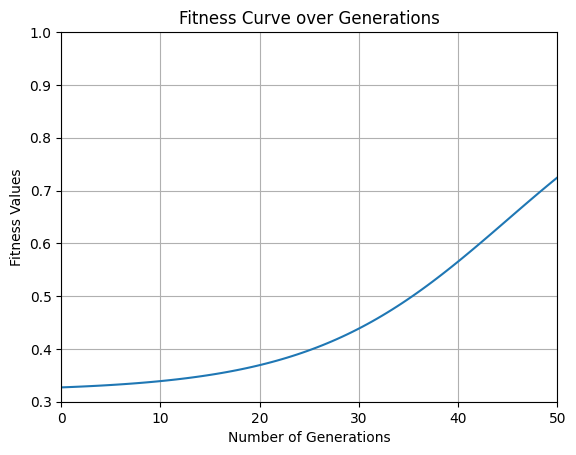

In [ ]:
# Main genetic algorithm loop
def genetic_algorithm_best_fitnesses():
    population = initialize_population()
    best_fitnesses = list()
    for _ in range(NUM_GENERATIONS):
        new_population = list()
        for _ in range(POPULATION_SIZE // 2):
            parents = select_parents(population)
            offspring = crossover(parents)
            mutated_offspring = mutate(offspring)
            new_population.extend(mutated_offspring)
        population = new_population
        best_individual = max(population, key=lambda x: evaluate_fitness(x))
        best_fitness = evaluate_fitness(best_individual)
        best_fitnesses.append(best_fitness)
    return best_fitnesses

# Run the genetic algorithm
best_fitnesses = genetic_algorithm_best_fitnesses()

# Plot the evolution of fitness over generations
plt.plot(range(NUM_GENERATIONS), best_fitnesses)
plt.xlabel('Number of Generations')
plt.ylabel('Fitness Values')
plt.title('Fitness Curve over Generations')
plt.show()




# Fin.